## **Vision Transformers (ViT) + DINO (Self-Supervised) for Melanoma Detection**

The aim of this notebook is to offer an analysis of how a Transformer model with self-supervised pretraining(DINO) performs on Melanoma image classification.

### **Author:** Jaime Corzo Galdó

---

## **Additional Information**

The documentation of the functions and comment formatting has been done with the integrated version of Google Gemini.

# **Libraries**

In [ ]:
import os
from google.colab import files
from fastai.vision.all import *
from pathlib import Path
import timm

# **Auxiliar Functions**

In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, recall_score
from fastai.vision.all import ClassificationInterpretation, get_image_files

# Index of the melanoma class

def melanoma_auc_recall(learn, dl, class_name='melanoma'):
    """
    Calculates and plots ROC-AUC and Recall for a specific class (one-vs-rest) using fastai outputs.

    This function:
      1) Uses a fastai Learner to obtain predicted class probabilities and true labels
         from a given DataLoader.
      2) Converts the multi-class problem into a binary one: (target class) vs (all other classes).
      3) Computes:
         - ROC-AUC using the predicted probability of the target class as the score.
         - Recall (sensitivity) using the hard prediction derived from argmax.

    Args:
        learn (fastai.learner.Learner):
            A trained fastai Learner.
        dl (fastai.data.core.DataLoader):
            The DataLoader to evaluate on (e.g., dls.train, dls.valid, or a test_dl).
        class_name (str):
            The name of the class to treat as the positive class (default: 'melanoma').

    Returns:
        tuple (auc, rec):
            - auc: ROC-AUC for (class_name vs rest)
            - rec: Recall for the positive class using argmax predictions
    """
    idx = learn.dls.vocab.o2i[class_name]

    preds, targs = learn.get_preds(dl=dl)   # preds: [N,C], targs: [N]

    # Scores y etiquetas binarias (melanoma vs resto)
    y_score = preds[:, idx].cpu().numpy()
    y_true  = (targs == idx).int().cpu().numpy()

    # Predicción binaria usando argmax multiclass
    y_pred = (preds.argmax(dim=1) == idx).int().cpu().numpy()

    auc = roc_auc_score(y_true, y_score)
    rec = recall_score(y_true, y_pred)

    print(f"ROC-AUC (melanoma vs resto) = {auc:.4f} | Recall(melanoma) = {rec:.4f}")

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f"ROC: {class_name} vs Rest")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return auc, rec

In [ ]:
def show_results(dls, learner, mode, melanoma_class='melanoma'):
    """
    Displays a confusion matrix and computes ROC-AUC + Recall for melanoma (or another class)
    for a chosen split: Train, Validation, or Test.

    Important note about the Test split:
    - Here we assume a folder structure like:
        test/
          nevus/
          melanoma/
          seborrheic_keratosis/
      so labels can be inferred from the parent folder name.
    - Therefore we collect test items with `get_image_files(test_path)` and create
      a dataloader via `learner.dls.test_dl(..., with_labels=True)`.

    Args:
        dls (fastai.data.core.DataLoaders):
            fastai DataLoaders containing train/valid configuration.
        learner (fastai.learner.Learner):
            A trained fastai Learner.
        mode (str):
            Must be one of: 'Train', 'Validation', 'Test'.
        melanoma_class (str):
            The class name to evaluate as positive in the ROC-AUC/Recall computation
            (default: 'melanoma').
    """
    print(f"\n{'='*20} Evaluating: {mode} {'='*20}")

    # 1. DataLoader Selector
    if mode == 'Validation': dl = dls.valid
    elif mode == 'Train':    dl = dls.train
    elif mode == 'Test':
        test_files = get_image_files(test_path)
        dl = learner.dls.test_dl(test_files, with_labels=True)
    else: raise ValueError("Mode must be 'Train', 'Validation' or 'Test'")

    # 2. Confusion Matrix and Global Accuracy
    interp = ClassificationInterpretation.from_learner(learner, dl=dl)
    interp.plot_confusion_matrix(figsize=(6, 6), title=f'Confusion Matrix ({mode})')
    plt.show()

    cm = interp.confusion_matrix()
    acc = np.trace(cm) / np.sum(cm) * 100
    print(f"✅ Global Accuracy: {acc:.2f}%")

    # 3. Call to the separate metrics function
    melanoma_auc_recall(learner, dl, class_name=melanoma_class)

# **Dataset Preparing**

## **Download**

To download the file and ensure no time is wasted, we decided to use Google Gemini to build a pipeline for downloading the dataset:

**You are an expert in Kaggle, datasets, deep learning and python. I need a pipeline to be able to download a dataset from Kaggle. You need to include flags to avoid downloading the dataset every time the cell is executed, as well as oher security flags. Manage resources in a way the access to the dataset is fast.**

---

<br>

After a few minor changes, we obtained an excellent pipeline to obtain the dataset without the need to download every time the cell is executed. This is only necessary when the environment is changed.

The authentication with Kaggle is carried out through the upload of a JSON file generated from the person's personal account. Once the file is uploaded, the zip containing the dataset will be downloaded, then unzipped and deleted.

Everything is managed in dymanic memory, so it is necessary to activate **High RAM Capacity** when selecting the environment.

In [ ]:
# --- 1. CONFIGURACIÓN DE KAGGLE API ---
kaggle_json_path = os.path.expanduser("~/.config/kaggle/kaggle.json")
token_setup_successful = False

# Verificar si kaggle.json ya existe
if not os.path.exists(kaggle_json_path):
    print("⬇️ Token no encontrado. Sube tu archivo kaggle.json ⬇️")
    uploaded = files.upload() # files.upload() returns a dict of uploaded files

    if 'kaggle.json' in uploaded:
        # Crear la carpeta oculta si no existe
        !mkdir -p ~/.config/kaggle
        # Mover el archivo json ahí dentro
        !mv kaggle.json ~/.config/kaggle/ # Usamos mv para evitar dejar una copia en /content
        # Dar los permisos de seguridad (lectura/escritura solo para ti)
        !chmod 600 ~/.config/kaggle/kaggle.json
        print("✅ Configuración completada: Fichero movido a ~/.config/kaggle/")
        token_setup_successful = True

        !pip install kaggle --quiet
        !kaggle --version
        from kaggle.api.kaggle_api_extended import KaggleApi
    else:
        print("❌ No se subió el archivo kaggle.json. Asegúrate de subirlo para continuar.")
else:
    print("✅ kaggle.json ya existe en ~/.config/kaggle/. Saltando la subida.")
    token_setup_successful = True

# Proceder con la autenticación y descarga solo si el token se configuró correctamente
if token_setup_successful:
    try:
        # Inicializamos la API (esto debe hacerse siempre para asegurar que la API está autenticada)
        # La API buscará automáticamente el archivo kaggle.json en ~/.config/kaggle/
        api = KaggleApi()
        api.authenticate()
        print("✅ Autenticación con Kaggle API exitosa.")

        # --- 2. DESCARGA DEL DATASET ---
        dataset_path = '/content/dataset'

        # Verificar si el dataset ya está descargado y descomprimido
        # Comprobamos si la carpeta existe y si contiene archivos
        if not os.path.exists(dataset_path) or not os.listdir(dataset_path):
            print("⏳ Descargando dataset en /content/dataset...")
            api.dataset_download_files(
                'wanderdust/skin-lesion-analysis-toward-melanoma-detection',
                path=dataset_path,
                unzip=True,
                quiet=False
            )
            print("✅ ¡Descarga finalizada!")

            # Borrar el archivo zip descargado para ahorrar espacio
            print("🧹 Limpiando archivos zip...")
            for file in os.listdir(dataset_path):
                if file.endswith(".zip"):
                    os.remove(os.path.join(dataset_path, file))
            print("✅ Archivo zip eliminado correctamente.")
        else:
            print("✅ Dataset ya descargado y descomprimido en /content/dataset/. Saltando la descarga.")
    except Exception as e:
        print(f"❌ Error durante la autenticación o descarga del dataset: {e}")
else:
    print("⚠️ No se puede proceder con la autenticación o descarga del dataset sin un archivo kaggle.json válido.")

✅ kaggle.json ya existe en ~/.config/kaggle/. Saltando la subida.
✅ Autenticación con Kaggle API exitosa.
✅ Dataset ya descargado y descomprimido en /content/dataset/. Saltando la descarga.


## **Creation of the Datablock**

In [ ]:
# List files and directories in the current working directory
!ls -lha
# List files and directories within the downloaded dataset path
!ls /content/dataset/skin-lesions/

total 24K
drwxr-xr-x 1 root root 4.0K Dec 29 12:53 .
drwxr-xr-x 1 root root 4.0K Dec 29 12:09 ..
drwxr-xr-x 4 root root 4.0K Dec  9 14:41 .config
drwxr-xr-x 3 root root 4.0K Dec 29 12:47 dataset
drwxr-xr-x 2 root root 4.0K Dec 29 12:56 models
drwxr-xr-x 1 root root 4.0K Dec  9 14:42 sample_data
test  train  valid


In [ ]:
# Define the base path for the dataset
path = Path("/content/dataset/skin-lesions")
# Define paths for training, validation, and test sets
train_path = path/'train'
valid_path = path/'valid'
test_path  = path/'test'

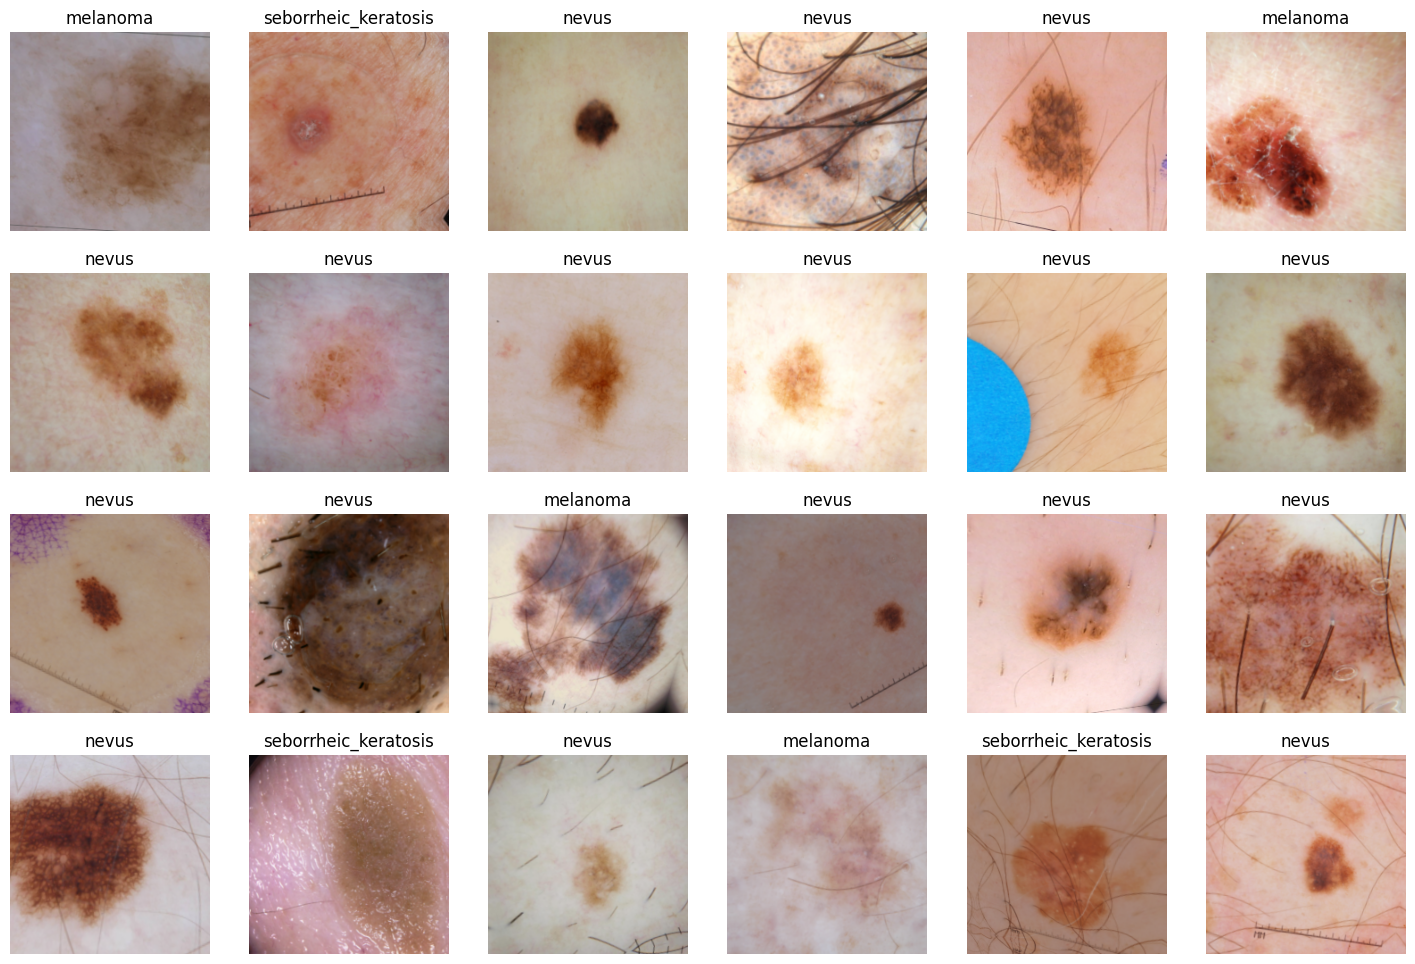

In [ ]:
# Create a DataBlock for image classification
dtblk = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # Define input (Image) and target (Category) blocks
    get_items=get_image_files,         # Function to get all image files
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'), # Split data based on 'train' and 'valid' folders
    get_y=parent_label,                # Function to get labels from parent folder names
    item_tfms=Resize(224),             # Apply resizing to 224x224 for individual items
    batch_tfms=[                       # Apply batch transformations (augmentation and normalization)
        *aug_transforms(do_flip=True, max_rotate=10, max_lighting=0.2),
        Normalize.from_stats(*imagenet_stats) # Normalize using ImageNet statistics
    ]
)

# Create DataLoaders from the DataBlock and the specified path, with a batch size of 32
dls=dtblk.dataloaders(path,bs=32)

# Display a batch of images with their labels
dls.show_batch(max_n=24)

# **Model Training**

## **1) What is a Transformer?**

- A **Transformer** is an architecture based on **self-attention**: each element of a sequence (token) can “look at” other tokens and combine information from them.
- Instead of processing the sequence step by step (as RNNs do), a Transformer processes many tokens **in parallel**.
- The key operation is **Scaled Dot-Product Attention**, which takes as input:
  - **Q** (queries), **K** (keys) of dimension $d_k$ and **V** (values) of dimension $d_v$, obtained by applying linear projections to the input embeddings. In practice, attention is computed for a set of queries at once, stacked into a matrix $Q$. Keys and values are also stacked into matrices $K$ and $V$. The output matrix is computed as:

\begin{equation}
Attention(Q,K,V)=softmax\Big(\frac{QK^{T}}{\sqrt{d_k}}\Big)V
\end{equation}

- Intuition behind the equation:
  - $QK^T$ computes “similarities” between tokens (which token should attend to which).
  - $\sqrt{d_k}$ stabilizes the softmax (prevents dot products from growing too large).
  - $softmax(\cdot)$ turns similarities into weights (they sum to 1).
  - The output is a weighted combination of the values \(V\).

### **Multi-Head Attention (MHA)**
- A Transformer uses **Multi-Head Attention (MHA)**. Instead of computing a single attention function, it is beneficial to linearly project the queries, keys, and values $h$ times using different learned linear projections, to dimensions $d_k$, $d_k$, and $d_v$ respectively.
- Several attentions are computed in parallel (“heads”).
- Each head can specialize in different relations (e.g., local vs global dependencies).
- Then they are concatenated and projected again.
- Example: In the sentence *The cat that was on the roof jumped*

  - One head may relate “cat” with “jumped”.

  - Another may relate “that” with “was”.

  - Another may focus on “roof” as context.

- With a single head, all these relations get mixed, and the model has a harder time capturing them clearly.

### **Why do we need positional embeddings?**
- Attention alone does not “know” which token comes first or second: order is not implicit.
- Therefore, **positional information** is added to each token.
- A classic (sinusoidal) version defines a positional vector $\vec{p}_t \in \mathbb{R}^{d}$ with sines and cosines at different frequencies:

\begin{equation}
\vec{p}_t(i)=
\begin{cases}
\sin(\omega_k\, t) & \text{if } i = 2k,\\
\cos(\omega_k\, t) & \text{if } i = 2k+1,
\end{cases}
\end{equation}

where

\begin{equation}
\omega_k = \frac{1}{10000^{\frac{2k}{d}}}.
\end{equation}

Finally, the positional embedding is added to the token embedding:
\begin{equation}
\psi'(w_t) = \psi(w_t) + \vec{p}_t.
\end{equation}


## **2) How is it adapted to vision? Vision Transformer (ViT)**

### **2.1. From image to sequence: patches as “tokens”**
- ViT turns an image into a **sequence of visual tokens**.
- The image is split into patches of size $P \times P$.
- If the image has size $H \times W$, the number of patches is:

\begin{equation}
N = \frac{H W}{P^2}
\end{equation}

- In the chosen model `vit_base_patch16_224`:
  - $H=W=224$, $P=16$
  - $\Rightarrow N=(224/16)^2=14^2=196$ patches.
- Each patch is flattened and linearly projected to dimension $D$ (embedding).
- In addition, a special token **[CLS]** (classification token) is added to obtain a global representation of the image.

### **2.2. Transformer Encoder over visual tokens**

- After converting each patch into an embedding of dimension $D$, we obtain a sequence:
  - 196 patch embeddings, plus the embedding of the **[CLS]** token.
- This forms an embedding matrix of size $(N+1) \times D$.
- The Transformer uses constant latent vectors (representations of the data in a lower-dimensional space) of size $D$, so after flattening the patches, we map them to $D$ dimensions using a trainable linear projection, as shown in the following equation.
- ViT adds a learnable **positional embedding** $E_{pos}$ with the same shape $(N+1)\times D$.
- Key operation: **element-wise sum**:

\begin{equation}
Z_0 = \big[\,x_{cls};\; x_{p}^{1}E;\;\dots;\;x_{p}^{N}E\,\big] + E_{pos}
\end{equation}

- Intuition:
  - $\big[\,x_{\mathrm{cls}};\; x_{p}^{1}E;\dots\big]$ are the embeddings; each $x_{p}^{i}$ is the $i$-th image patch of size $P^2C$ ($C$ is the number of channels), and $E$ is the linear projection matrix that maps each patch to the model dimension $D$.
  - $E_{pos}$ injects “where each patch is” in the image.
  - Since the sum does not change dimensionality, the Transformer can consume the sequence just like in NLP.

#### **2.2.1 The sequence passes through $L$ Transformer encoder blocks**
- A **Transformer encoder** is a stack of $L$ identical blocks.
- Each block has two main sublayers:
  - **MHA**: Multi-Head Self-Attention.
  - **MLP**: Multi-Layer Perceptron.

- In ViT, a **pre-norm** scheme is typically used:
  - **LayerNorm (LN)** is applied before each sub-block,
  - **residual connections** (skip connections) are used after each sub-block.

If we denote $Z_{\ell-1}$ as the token sequence (matrix $(N+1)\times D)$ at the input of block $\ell$:

1) Attention sub-block (MHA):
\begin{equation}
\hat{Z}_\ell = Z_{\ell-1} + MHA(LN(Z_{\ell-1}))
\end{equation}

2) MLP sub-block (token-wise feed-forward):
\begin{equation}
Z_\ell = \hat{Z}_\ell + MLP(LN(\hat{Z}_\ell))
\end{equation}

- Intuition:
  - **MHA** “mixes” information across patches: one patch can attend to other relevant patches.
  - **MLP** processes each token (each patch) non-linearly to refine the representation.
  - Residual connections $(+ Z)$ help stabilize training and improve gradient flow.


## **3) DINO: A form of self-distillation without labels**

### **3.1. What does “self-supervised” mean if it uses ImageNet images?**
- **Self-supervised** does NOT mean “no data”; it means **no labels**.
- In DINO, ImageNet-1k is used as the image dataset, but:
  - **ImageNet labels are NOT used** (the 1000 classes).
  - The “objective” (training signal) is built from:
    - augmentations (different views/crops of the same image),
    - and teacher-student consistency (self-distillation).
- We take a self-supervised pretrained model, DINO, and we do a training with labels(linear probe + fine-tuning) which is supervised transfer learning over the self-supervised backbone.
- Self-supervised learning focuses on learning generalizable representations through pretext tasks that are not directly related to the final goal. These learned representations can then be fine-tuned on labeled data for downstream tasks, making self-supervised learning a powerful tool for transfer learning.

### **3.2. DINO idea: teacher-student + multi-crop + EMA**
- DINO trains two networks with the **same architecture** (here, ViT):
  - **student**: trained with gradients (backprop).
  - **teacher**: not trained by direct gradients; it is updated as an exponential moving average (EMA) of the student.
- **Distillation** is the process where you train a large model (the teacher) on a dataset, and if you want a smaller model, you use the dataset and the teacher to transfer knowledge to the student, which usually works better than training the student from scratch.
- The idea is as follows (simplified): starting from an image $x$, we create two different versions $x_1$ and $x_2$ (global views (large crops) and local views (small crops)), and the objective is to minimize the loss at the output of the model, i.e., teach the network that even if $x_1$ and $x_2$ look different, they are actually the same image.
- The student and teacher networks have different parameters, since otherwise this could lead to **collapse** (we want to avoid the network predicting that both are the same because everything becomes identical).
- In DINO, stop-gradient (sg) is applied to the teacher so gradients only flow through the student. The teacher parameters are updated using an **exponential moving average (EMA)** of the student parameters. That is, we train the student to match the teacher (learning from it), and after updating the student, we update the teacher using the updated student.

### **3.3. Loss: cross-entropy between teacher and student**

#### **(A) What is cross-entropy?**
- **Cross-entropy** measures how well a predicted distribution $Q$ matches a target distribution $P$.
- General form:

\begin{equation}
H(P,Q)= -\sum_{k=1}^{K} P^{(k)} \log\big(Q^{(k)}\big)
\end{equation}

- Intuition:
  - if $P^{(k)}$ is large (the target assigns high probability to component $k$) but $Q^{(k)}$ is small, the term $-P^{(k)}\log(Q^{(k)})$ penalizes strongly.


#### **(B) How is it applied in DINO?**
- Given an image $x$, two views (augmentations) $x_1$ and $x_2$ are generated from the same image.
- The **teacher** $g_{\theta_t}$ and the **student** $g_{\theta_s}$ produce logits (pre-softmax outputs) of dimension $K$.
- Their probability distributions are obtained by softmax normalization (with temperatures $\tau_t$ and $\tau_s$):

\begin{equation}
P_t(x_1)^{(i)}=\frac{\exp\left(\left(g_{\theta_t}(x_1)^{(i)}-c^{(i)}\right)/\tau_t\right)}
{\sum\limits_{k=1}^{K}\exp\left(\left(g_{\theta_t}(x_1)^{(k)}-c^{(k)}\right)/\tau_t\right)},
\qquad
P_s(x_2)^{(i)}=\frac{\exp\left(g_{\theta_s}(x_2)^{(i)}/\tau_s\right)}
{\sum\limits_{k=1}^{K}\exp\left(g_{\theta_s}(x_2)^{(k)}/\tau_s\right)}.
\end{equation}

- Interpretation of the terms:
  - $g_{\theta_t}(\cdot)$: (logits) output of the **teacher** for one view (typically a *global crop*).
  - $g_{\theta_s}(\cdot)$: (logits) output of the **student** for the other view (global or *local crop*).
  - $c$: **centering** vector (subtracted only from the teacher to help avoid collapse).
  - $\tau_t, \tau_s$: **temperatures** (the teacher often uses lower $\tau_t$ to produce more “sharpened” distributions).


#### **(C) DINO loss**
- The typical loss is defined as cross-entropy between the teacher and student distributions:

\begin{equation}
\mathcal{L}(x_1,x_2)=H\big(P_t(x_1),P_s(x_2)\big)
= -\sum_{i=1}^{K} P_t(x_1)^{(i)} \log\big(P_s(x_2)^{(i)}\big).
\end{equation}

- In DINO, **stop-gradient** is used on the teacher:
  - when computing the gradient of $\mathcal{L}$, $P_t(x_1)$ is treated as constant (no backpropagation through the teacher);
  - the teacher is updated via an exponential moving average (EMA) of the student weights.


## **4) Meaning of the pipeline: Linear Probe + Fine-tuning**

### **4.1. Linear probe (frozen encoder)**
- Objective: measure the quality of the DINO model representations “as is”.
- Procedure:
  - freeze the ViT-DINO backbone,
  - train only a linear head for the 3 classes:
    - nevus / melanoma / seborrheic keratosis.
- Interpretation:
  - if it performs well with a simple head, it suggests the embedding space is “separable” and useful.

### **4.2. Fine-tuning (domain adaptation)**
- Objective: adapt the backbone to the **domain shift**:
  - ImageNet (general objects) vs dermoscopy (skin lesions).
- Procedure:
  - unfreeze part or all of the backbone,
  - train with a lower LR on the backbone and a higher LR on the head.
- Interpretation:
  - compared to linear probe, this quantifies how much the model “gains” by specializing to the dataset.

---

## *Main references*
- Transformer: Vaswani et al., *Attention Is All You Need*, 2017.
- ViT: Dosovitskiy et al., *An Image is Worth 16x16 Words*, 2020/2021.
- DINO: Caron et al., *Emerging Properties in Self-Supervised Vision Transformers*, 2021.


## **Pipeline**

This section describes the **end-to-end training pipeline** used.


## **1) Data setup and preprocessing**

- **Dataset structure:** images are organized in `train/`, `valid/`, and `test/` folders, each containing one subfolder per class.
- **Splitting strategy:** we rely on `GrandparentSplitter(train_name='train', valid_name='valid')` so that fastai automatically builds the train/validation splits from the folder hierarchy.
- **Image size:** all images are resized to **224x224**.
- **Normalization:** images are normalized using **ImageNet statistics** (`imagenet_stats`), which is consistent with timm's pretrained ViT/DINO models.


## **2) Model definition (SSLClassifier wrapper)**

We use the timm backbone `vit_*_patch16_224.dino` and wrap it as:

- **Backbone (encoder):** pretrained DINO ViT that outputs an embedding vector of size **D** (for ViT-S/16, typically **D=384**).
- **Head (classifier):** a linear layer mapping the embedding to 3 logits (one per class).

This explicit separation is important because it enables a clean comparison between:

- **Linear probing** (frozen backbone, train only the linear head)
- **Fine-tuning** (unfreeze part/all of the backbone and adapt to dermoscopy)

We also define a **splitter** (`ssl_splitter`) that creates two parameter groups (backbone vs head), which is crucial for correct freezing/unfreezing behavior in fastai.


## **3) Stage A — Linear Probe (frozen backbone)**

### **Motivation**
The goal of a **linear probe** is to measure how good the pretrained representations are *without adapting the backbone*.  
If a simple linear classifier already performs well, it indicates that the DINO embedding space is already separable for this downstream task.

### **Procedure**
- Freeze the backbone (`learn_ssl.freeze()`), so **only the head is trainable**.
- Run `lr_find()` to obtain a reasonable learning rate for the head.
- Train with **1Cycle** scheduling (`fit_one_cycle`), which typically converges fast in this stage.
- Initially, this was done without callbacks, but later stabilized with:
  - `SaveModelCallback(monitor='valid_loss')`
  - `EarlyStoppingCallback(monitor='valid_loss')`

### **Observations**
- With the larger `vit_base_patch16_224.dino` model (≈80M params), training was prone to **overfitting** and **high variance** in validation curves.
- Increasing epochs helped convergence, but often worsened generalization without stronger regularization.


## **4) Stage B — Fine-tuning (partial unfreeze)**

### **Motivation**
The dermoscopy domain differs significantly from ImageNet-like imagery (**domain shift**).  
Fine-tuning allows the backbone to adapt higher-level features to lesion morphology and texture.

### **Procedure**
- Unfreeze the model (`learn_ssl.unfreeze()`).
- Run a separate `lr_find()` for fine-tuning.
- Add stronger regularization:
  - **Weight decay increased** (e.g., from ~0.1 to ~0.2)
  - **MixUp** introduced (alpha increased from 0.2 $\rightarrow$ 0.4)
  - `reset_opt=True` to reinitialize the optimizer state before fine-tuning (avoids carrying momentum/Adam moments from the linear-probe stage).

### **Observations**
- Fine-tuning generally improved **macro F1** and validation stability compared to linear probe alone.
- However, large models + small dataset size led to recurrent overfitting.
- A key improvement was switching from the **ViT-Base DINO** backbone to **ViT-Small DINO**, reducing capacity and improving generalization.


## **5) Regularization and stability changes**

Over the course of experimentation, multiple adjustments were made to reduce overfitting and stabilize validation performance:

- **Model capacity reduction**
  - From `vit_base_patch16_224.dino` (very high capacity)  
  - To `vit_small_patch16_224.dino` (smaller, less prone to overfit)

- **Loss function**
  - From standard cross-entropy to **Label Smoothing Cross Entropy**, which reduces over-confident predictions and improves generalization.

- **Data augmentation**
  - Increased progressively to reduce memorization and encourage robustness.

- **Weight decay**
  - Increased gradually (e.g., 0.01 $\rightarrow$ 0.1 $\rightarrow$ 0.2) to regularize weights.

- **Callbacks**
  - `SaveModelCallback` to keep the best checkpoint according to validation loss.
  - `EarlyStoppingCallback` to stop before overfitting dominates.

- **MixUp**
  - Added to reduce overfitting and improve robustness; alpha was tuned upward (0.2 -> 0.4).

- **FP16 mixed precision (`to_fp16()`)**
  - Used mainly to **reduce GPU memory usage** and **speed up training**.
  - FP16 is **not a regularization method** by itself; it typically does **not** directly reduce overfitting, but it can enable larger batch sizes or faster experimentation, which indirectly helps tuning.


After some tuning, the best combination of hyperparameters which delivered the best compromise between convergence speed, validation stability, and test generalization turned out to be the following:

In [ ]:
import torch
import torch.nn as nn

MODEL_NAME = "vit_small_patch16_224.dino"

# ------------------------------------------------------------------------------
# We want a PyTorch classification model with two clearly separated parts:
#
# 1) Backbone / encoder: a pretrained ViT (DINO) that converts an image into a
#    feature vector (embedding).
# 2) Head / classifier: a linear layer that converts that embedding into logits
#    for the 3 classes (nevus / melanoma / seborrheic keratosis).
#
# Design goals:
# 1) Enable "linear probe": freeze the backbone and train only the head.
# 2) Enable "fine-tuning": unfreeze (part of) the backbone to adapt to the domain.
# ------------------------------------------------------------------------------
class SSLClassifier(nn.Module):
    """
    We define a new class called SSLClassifier that inherits from nn.Module,
    the base class for all neural network modules in PyTorch.

    This inheritance allows SSLClassifier to leverage nn.Module functionality,
    such as automatic registration of trainable parameters and submodules,
    which is required for correct optimization and checkpointing.
    """

    def __init__(self, model_name: str, n_classes: int):
        """
        Model constructor.

        Parameters
        ----------
        model_name : str
            Model name in timm, e.g. "vit_base_patch16_224.dino".
        n_classes : int
            Number of classes in the task (dls.c).

        Notes
        ----------
        - `self` is a reference to the current object (the class instance).
        - `super().__init__()` calls the nn.Module constructor.
          This is required so PyTorch can correctly track parameters/submodules.
        - `timm.create_model(..., pretrained=True)` loads pretrained weights.
        - `num_classes=0` in timm means "do not create a classification head";
          the model behaves as a feature extractor.
        - In short, `self.backbone(x)` takes an image tensor and returns an embedding.
        """
        super().__init__()

        # Backbone: pretrained ViT (DINO) used as an encoder (feature extractor).
        # NOTE: Requires `import timm` earlier.
        self.backbone = timm.create_model(
            model_name,
            pretrained=True,
            num_classes=0,        # remove the original classification head
            drop_path_rate=0.2    # stochastic depth (regularization) inside the transformer blocks
        )

        # `d` is the number of features produced by the backbone (embedding dimension).
        d = getattr(self.backbone, "num_features", None)
        if d is None:
            raise ValueError("Could not infer num_features from the backbone.")

        # Classification head: maps embedding [B, D] -> logits [B, n_classes].
        self.head = nn.Linear(d, n_classes)

    def forward(self, x):
        """
        Defines the forward pass. When you call:
            pred = model(x)
        PyTorch internally calls:
            pred = model.forward(x)

        - Input:  x with shape [B, C, H, W]
        - Output: logits with shape [B, n_classes]
        """
        feats = self.backbone(x)   # [B, D] feature embedding
        logits = self.head(feats)  # [B, n_classes] class logits
        return logits


def ssl_splitter(m):
    """
    Function used by fastai to group parameters into "parameter groups".
    It returns two groups: backbone parameters and head parameters.

    This is useful because fastai can:
    - freeze/unfreeze groups (e.g., linear probe),
    - apply different learning rates to different groups (discriminative LRs).
    """
    # NOTE: Requires fastai utilities: `L` and `params` to be available/imported.
    return L(m.backbone, m.head).map(params)


# dls.c is the number of classes
model = SSLClassifier(MODEL_NAME, dls.c)

learn_ssl = Learner(
    dls,
    model,
    # Loss for multi-class classification with label smoothing (fastai variant).
    loss_func=LabelSmoothingCrossEntropyFlat(),
    # Metrics: overall accuracy + macro F1 (treats classes equally).
    metrics=[accuracy, F1Score(average='macro')],
    # Splitter defines parameter groups (backbone vs head).
    splitter=ssl_splitter,
    # Optimizer: Adam with "momentum-like" setting.
    opt_func=partial(Adam, mom=0.9)
).to_fp16()  # Use mixed precision (FP16) for faster training and lower GPU memory usage


In [ ]:
# ------------------------------------------------------------------------------
# A) Linear probe
# ------------------------------------------------------------------------------
# In fastai, `freeze()` freezes all parameter groups except the last one.
# With our `ssl_splitter`, the groups are:
#   - Group 0: backbone (ViT-DINO encoder)
#   - Group 1: head (linear classifier)
# So, `freeze()` will keep the head trainable and freeze the backbone.
# For a 3-class linear head with embedding dimension d = 384, the head contains
# n_classes·d + n_classes = 3·384 + 3 = 1,155 parameters. The remaining trainable
# parameters come from the unfrozen LayerNorm layers in the backbone, bringing
# the total number of trainable parameters to 20,355 during the linear-probe stage.
learn_ssl.freeze()

# Print a model summary (layers, parameter counts, and trainable status).
learn_ssl.summary()

SSLClassifier (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 384 x 14 x 14  
Conv2d                                    295296     False     
Identity                                                       
Dropout                                                        
Identity                                                       
Identity                                                       
LayerNorm                                 768        True      
____________________________________________________________________________
                     32 x 197 x 1152     
Linear                                    443520     False     
Identity                                                       
Identity                                                       
Identity                                                       
Linear                                    147840     False     
Dropout                

## **Explicación del summary**

### **A) Entrada**
- Input: $32 \times 3 \times 224 \times 224$. Batch de $32$ imágenes RGB $224 \times 224$.

### **B) Patch Embedding**

- En ViT, la primera Conv2d hace la tokenización de patches:

  - Kernel = $16 \times 16$, stride = $16$

  - Divide $224 \times 224$ en una cuadrícula de $14 \times 14$ patches (porque 224/16 = 14)

  - Por eso la salida es: $32 \times 384 \times 14 \times 14$

  - Interpretación: $14 \times 14 = 196$ patches, cada patch se proyecta a un vector de dimensión D = 384. Este es el tamaño del vector que representa cada token (cada patch y el CLS). Cada token es un vector en $\mathbb{R}^{384}$.

### **C) De imagen a secuencia: 196 tokens + [CLS] = 197 tokens**

- Después se reordena a forma secuencial: $32 \times 384 \times 14 \times 14 \rightarrow 32 \times 196 \times 384$ y se añade el token [CLS]: $32 \times (196 + 1) \times 384 = 32 \times 197 \times 384$.

- Por eso a partir de ahí aparece 197 constantemente: 197 = número de tokens (1 CLS + 196 patches).

- Con esto tendríamos casi la primera operación grande del Transformer, que consiste en que en cada bloque, proyecta cada token para obtener **Q, K, V**(queries, keys, values). En atención, se usa una capa lineal que hace:

\begin{equation}
Linear(D \rightarrow 3D)
\end{equation}

- Con $D = 384$:

\begin{equation}
3D = 3*384 = 1152
\end{equation}

- Esa dimensión $1152$ no es “la imagen aplastada”, sino (Q|K|V) concatenado para cada token.

### **D) Siguientes bloques formados por:**
1. Atención (MHA) con dimensión base $D=384$

2. MLP que expande y comprime: $384 \rightarrow 1536 \rightarrow 384$, ya que el MLP ratio suele ser $x4$.

- Por eso podemos ver:

  - $32 \times 197 \times 1536$ (expansión).

  - Luego vuelve a $32 \times 197 \times 384$ (compresión).

### **E) Layer Norm**
- En un LayerNorm hay dos vectores entrenables:

  - $\gamma \in \mathbb{R}^{D}$
  - $\beta \in \mathbb{R}^{D}$

- Total: $2D = 2*384 = 768$.

SuggestedLRs(valley=0.0005754399462603033)

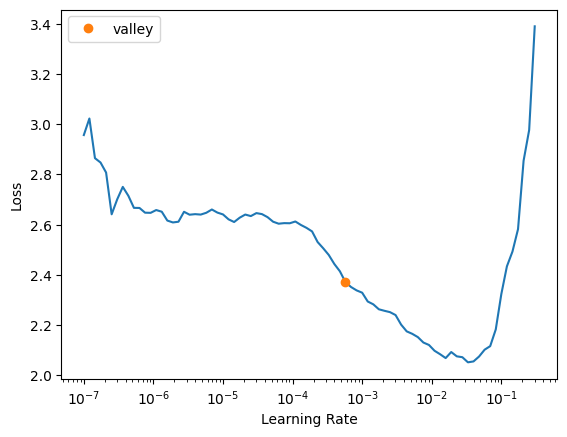

In [ ]:
# `lr_find()` runs a short LR range test: it gradually increases the learning rate
# over a few iterations and tracks how the loss behaves.
# The goal is to estimate a good learning rate for training (especially useful
# before using the 1Cycle policy).
#
# In fastai, `lr_find()` returns a suggested learning rate value (or values,
# depending on the version/config). We store the returned suggestion in
# `learn_rate_probe` and then use it as `lr_max` in `fit_one_cycle()`.
learn_rate_probe = learn_ssl.lr_find()
learn_rate_probe

In [ ]:
# ------------------------------------------------------------------------------
# Linear probe training (backbone frozen, head trainable)
# ------------------------------------------------------------------------------
start_linear_probe = time.time()

# Callbacks:
# - SaveModelCallback: saves the model weights whenever `valid_loss` improves.
#   This ensures we keep the best checkpoint (best generalization on validation).
# - EarlyStoppingCallback: stops training if `valid_loss` has not improved for
#   `patience` epochs, reducing unnecessary training and limiting overfitting.
cbs = [
    SaveModelCallback(monitor='valid_loss', fname='best_vit_linear_probe'),
    EarlyStoppingCallback(monitor='valid_loss', patience=3)
]

# Train for up to 10 epochs using the 1Cycle learning rate schedule.
# - `lr_max=learn_rate_probe`: uses the LR suggested by the LR range test.
# - `wd=0.01`: weight decay (L2 regularization) to help reduce overfitting.
learn_ssl.fit_one_cycle(10, lr_max=learn_rate_probe, wd=0.01, cbs=cbs)

# After training, load the best checkpoint saved according to `valid_loss`.
# This ensures subsequent evaluation uses the best-performing (validation) model.
learn_ssl.load('best_vit_linear_probe')

end_linear_probe = time.time()

# Report the elapsed time for the linear probe stage.
print(f"Tiempo de entrenamiento del linear probe: {end_linear_probe - start_linear_probe:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.415796,1.658093,0.420000,0.314421,00:58
1,1.161802,1.115597,0.560000,0.488204,00:57
2,0.992895,0.952283,0.646667,0.564453,00:57
3,0.888491,0.907561,0.673333,0.577346,00:56
4,0.816193,0.822672,0.700000,0.612359,00:56
5,0.783311,0.816972,0.673333,0.599727,00:57
6,0.751733,0.826682,0.646667,0.566488,00:57
7,0.729467,0.784099,0.700000,0.634384,00:57
8,0.717299,0.779318,0.686667,0.617560,00:58
9,0.717981,0.781012,0.686667,0.617560,00:56


Better model found at epoch 0 with valid_loss value: 1.6580926179885864.
Better model found at epoch 1 with valid_loss value: 1.1155972480773926.
Better model found at epoch 2 with valid_loss value: 0.9522834420204163.
Better model found at epoch 3 with valid_loss value: 0.9075605273246765.
Better model found at epoch 4 with valid_loss value: 0.8226722478866577.
Better model found at epoch 5 with valid_loss value: 0.8169723749160767.
Better model found at epoch 7 with valid_loss value: 0.7840993404388428.
Better model found at epoch 8 with valid_loss value: 0.7793182730674744.
Tiempo de entrenamiento del linear probe: 575.71 segundos


/usr/local/lib/python3.12/dist-packages/fastai/learner.py:67: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


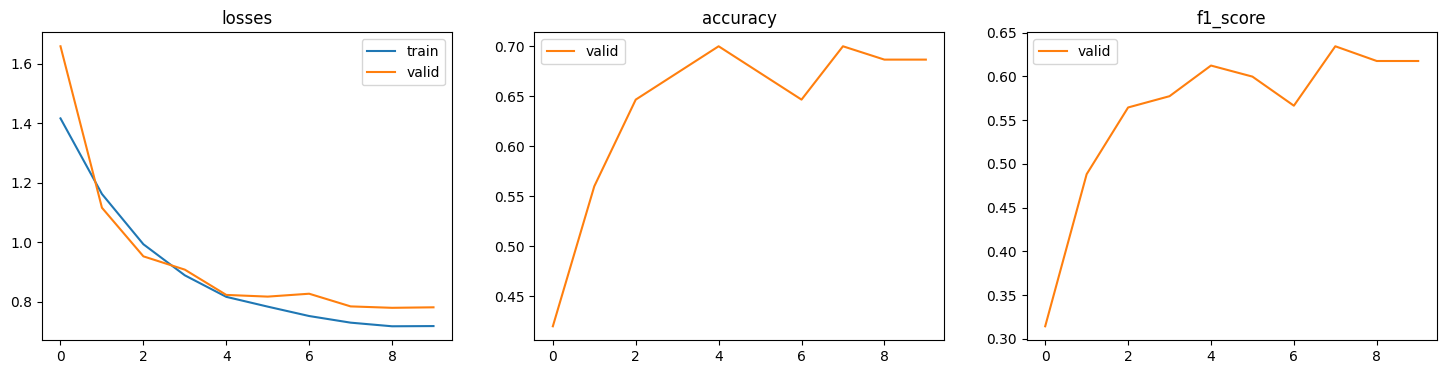

In [ ]:
learn_ssl.recorder.plot_metrics()

## **Linear Probe Analysis**

### **1. Loss behavior (train vs valid):**

- Both train and validation loss drop sharply in the first 2-4 epochs, which is what you want in a linear probe: the pretrained DINO features are immediately useful for separating classes with a simple linear layer.

- After ~epoch 4, the validation loss slightly oscillates while training loss continues to decrease slowly. This suggests you are reaching the limit of what a linear classifier can extract from the frozen features, and any further optimization mostly improves fit on the training set rather than generalization.

### **Accuracy (validation):**

- Validation accuracy rises quickly from ~0.42 to roughly 0.65-0.70 and then stabilizes with small fluctuations.

- The fluctuations are expected given the small validation set (150 images), which makes the metric high-variance.

### **Macro F1 (validation):**

- Macro F1 increases from ~0.31 to about 0.60-0.64, which is consistent with the accuracy trend.

- Using macro F1 is a good choice here because it reflects performance across all classes (not dominated by the majority class). The fact it is somewhat lower than accuracy is typical when there is class imbalance or when one class remains harder to classify.

### **Overfitting assessment:**

- There is mild overfitting after the mid-training point (train loss keeps improving, valid loss stops improving), but it is not extreme. In linear probe this is common: the head can still over-specialize even though it is small.

### **Interpretation:**

- These results support the claim that DINO-pretrained representations transfer well to dermoscopy: with the backbone frozen, a simple linear classifier already achieves ~0.7 validation accuracy and ~0.62 macro F1. Fine-tuning should be framed as the next step to handle the domain shift.

In [ ]:
# ------------------------------------------------------------------------------
# B) Fine-tuning
# ------------------------------------------------------------------------------
# `unfreeze()` makes all parameter groups trainable again.
# With our `ssl_splitter`, this means:
#   - the ViT-DINO backbone (encoder) becomes trainable
#   - the classification head remains trainable
# Now all the parameters of the model will be trainable, this phase is normally
# done with a smaller learning rate.
learn_ssl.unfreeze()

# Print a model summary (layers, parameter counts, and trainable status).
learn_ssl.summary()

SSLClassifier (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 384 x 14 x 14  
Conv2d                                    295296     True      
Identity                                                       
Dropout                                                        
Identity                                                       
Identity                                                       
LayerNorm                                 768        True      
____________________________________________________________________________
                     32 x 197 x 1152     
Linear                                    443520     True      
Identity                                                       
Identity                                                       
Identity                                                       
Linear                                    147840     True      
Dropout                

SuggestedLRs(valley=0.007585775572806597)

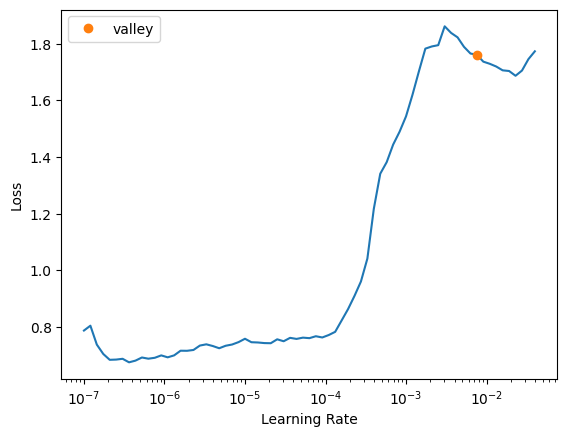

In [ ]:
# `lr_find()` runs a short LR range test: it gradually increases the learning rate
# over a few iterations and tracks how the loss behaves.
# The goal is to estimate a good learning rate for training (especially useful
# before using the 1Cycle policy).
#
# In fastai, `lr_find()` returns a suggested learning rate value (or values,
# depending on the version/config). We store the returned suggestion in
# `learn_rate_finetune`.
learn_rate_finetune = learn_ssl.lr_find()
learn_rate_finetune

In [ ]:
# ------------------------------------------------------------------------------
# Fine-tuning training
# ------------------------------------------------------------------------------
start_fine_tune = time.time()

# Callbacks:
# - MixUp: strong regularization that blends images and labels, helping reduce overfitting.
# - SaveModelCallback: saves the best model checkpoint based on validation loss.
# - EarlyStoppingCallback: stops training if validation loss does not improve for a few epochs.
cbs = [
    MixUp(alpha=0.4),
    SaveModelCallback(monitor='valid_loss', fname='best_vit_dino'),
    EarlyStoppingCallback(monitor='valid_loss', patience=3)
]

# We fine-tune using the 1Cycle policy with a conservative maximum learning rate:
#   lr_max = 1e-6
#
# Justification for choosing a much smaller LR than the suggested "valley":
# - The LR range test shows the loss becomes unstable at higher learning rates.
#   A safe strategy is to pick an LR well below the instability region, prioritizing
#   stable, incremental adaptation rather than fast but noisy updates.
# - With MixUp and strong weight decay (wd=0.2), training is already strongly regularized;
#   a smaller LR helps ensure updates remain controlled.
learn_ssl.fit_one_cycle(12, lr_max=1e-6, wd=0.2, cbs=cbs, reset_opt=True)

# Load the best checkpoint (lowest validation loss) for evaluation/inference.
learn_ssl.load('best_vit_dino')

end_fine_tune = time.time()

# Report elapsed time for the fine-tuning stage.
print(f"Tiempo de entrenamiento del fine-tuning: {end_fine_tune - start_fine_tune:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.781419,0.834915,0.686667,0.571810,01:00
1,0.778813,0.769435,0.700000,0.618851,00:57
2,0.779950,0.783231,0.693333,0.588039,00:57
3,0.769440,0.753134,0.720000,0.651885,00:57
4,0.748436,0.741045,0.746667,0.680011,00:56
5,0.754093,0.737215,0.733333,0.678708,00:58
6,0.741860,0.739012,0.706667,0.645371,00:58
7,0.739495,0.745750,0.740000,0.662497,00:57
8,0.731017,0.731081,0.746667,0.681620,00:57
9,0.737126,0.716607,0.780000,0.728197,00:56


Better model found at epoch 0 with valid_loss value: 0.8349153399467468.
Better model found at epoch 1 with valid_loss value: 0.7694345116615295.
Better model found at epoch 3 with valid_loss value: 0.7531335353851318.
Better model found at epoch 4 with valid_loss value: 0.7410446405410767.
Better model found at epoch 5 with valid_loss value: 0.7372151017189026.
Better model found at epoch 8 with valid_loss value: 0.7310808300971985.
Better model found at epoch 9 with valid_loss value: 0.7166069746017456.
Tiempo de entrenamiento del fine-tuning: 693.97 segundos


/usr/local/lib/python3.12/dist-packages/fastai/learner.py:67: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


Tiempo total de entrenamiento: 25.16 minutos


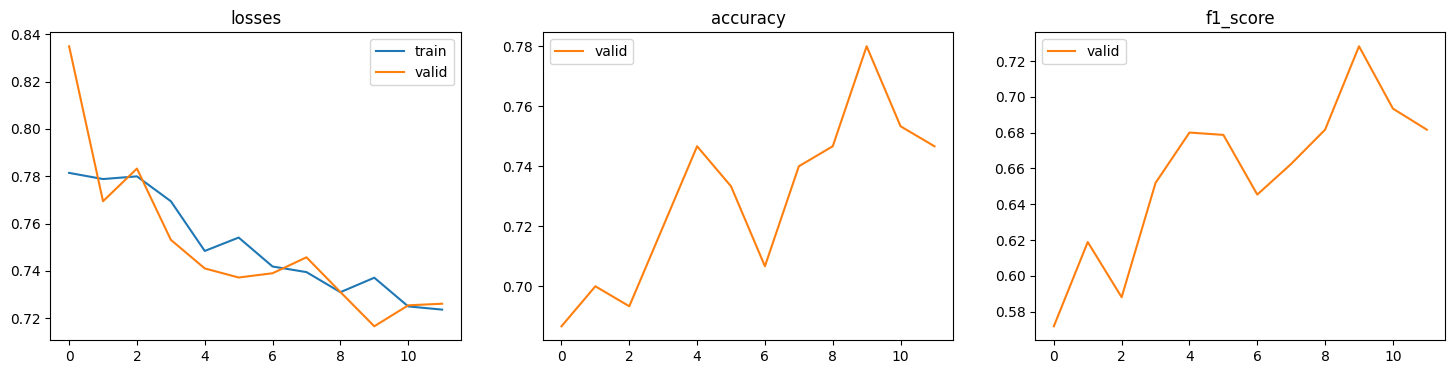


==================== Evaluating: Train ====================


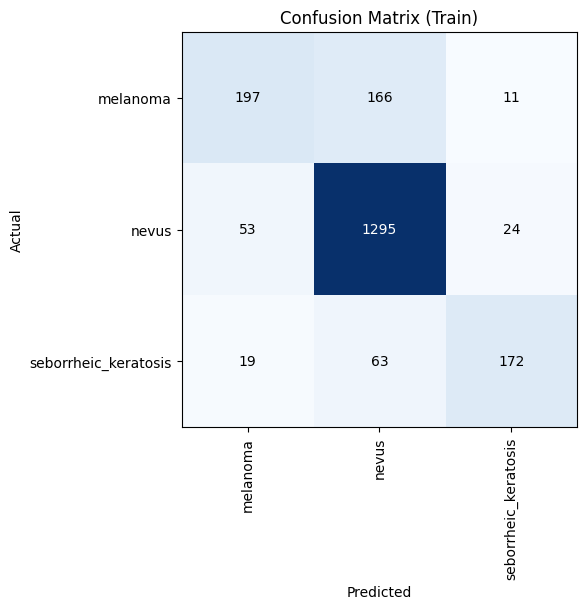

✅ Global Accuracy: 82.55%


ROC-AUC (melanoma vs resto) = 0.8763 | Recall(melanoma) = 0.5080


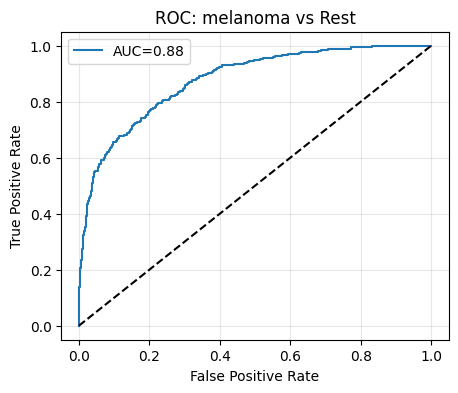


==================== Evaluating: Validation ====================


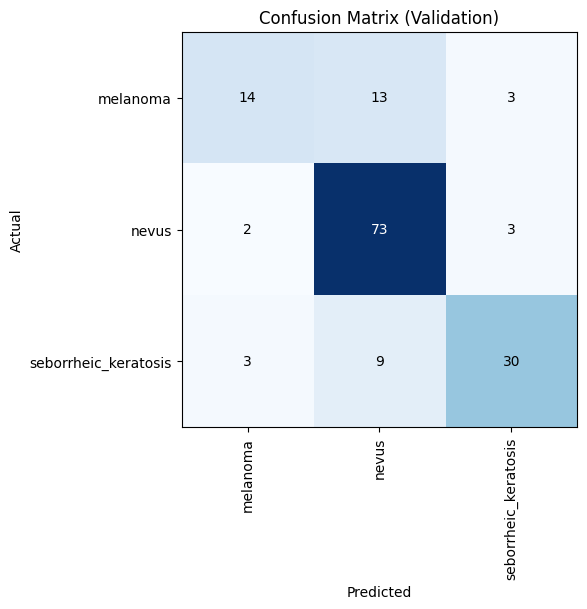

✅ Global Accuracy: 78.00%


ROC-AUC (melanoma vs resto) = 0.8464 | Recall(melanoma) = 0.4667


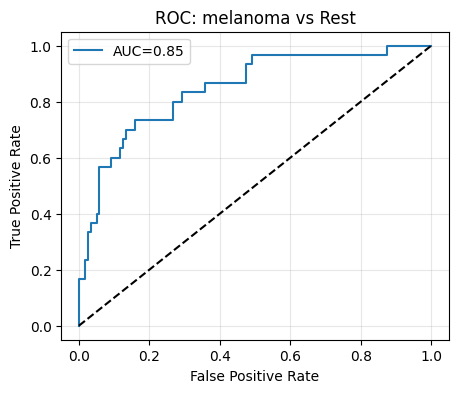


==================== Evaluating: Test ====================


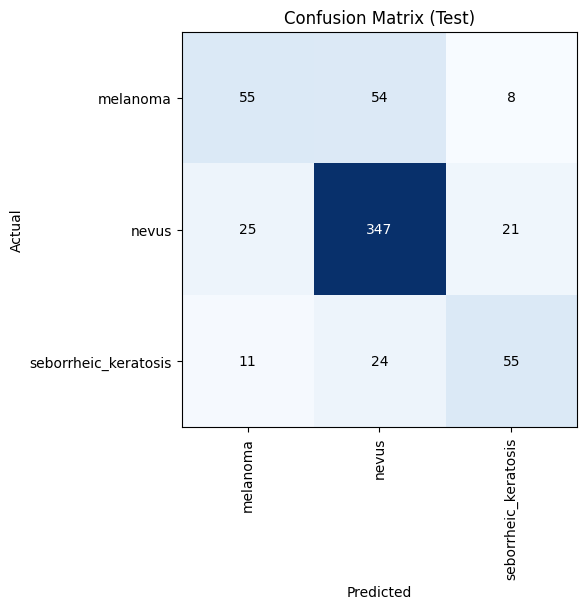

✅ Global Accuracy: 76.17%


ROC-AUC (melanoma vs resto) = 0.8292 | Recall(melanoma) = 0.4701


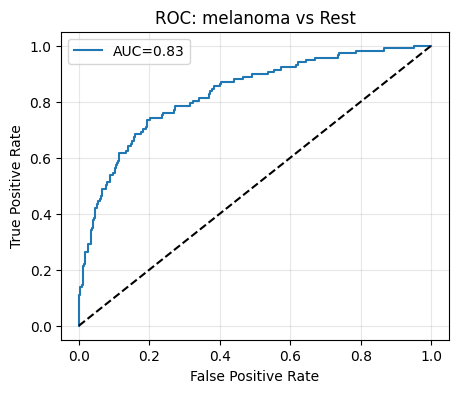

In [ ]:
print(f"Tiempo total de entrenamiento: {(end_fine_tune - start_linear_probe)/60:.2f} minutos")

learn_ssl.recorder.plot_metrics()

show_results(dls, learn_ssl, 'Train')

show_results(dls, learn_ssl, 'Validation')

show_results(dls, learn_ssl, 'Test')

## **Final Analysis**

### **1. Loss curves (train vs. valid):**
- Training and validation loss decrease together from ~0.78/0.84 down to ~0.72-0.73, and they remain close throughout training. This indicates good training stability and limited overfitting: the model improves on the training set without a widening gap in validation loss. The small oscillations in validation loss are expected given the relatively small validation split.

### **2. Validation accuracy:**
- Validation accuracy shows a clear upward trend overall (from 0.69 to a peak around 0.78), followed by a slight drop towards the end (~0.75). This pattern suggests that the model reaches its best generalization performance around the peak epoch, and that later epochs provide diminishing returns. Using SaveModelCallback(monitor='valid_loss') is therefore important.

### **3. Validation F1-score:**
- Macro F1 increases substantially (from ~0.57 to a peak around 0.73), which is a strong sign that fine-tuning improved balanced performance across classes, not just overall accuracy. The fact that macro F1 rises along with accuracy indicates improved class separability and fewer systematic errors in minority/harder classes.

### **4. Overall takeaway:**
- Compared to the linear probe stage, fine-tuning delivers a clear improvement: validation accuracy and macro F1 both increase, while the loss curves remain well aligned between train and validation. This suggests that fine-tuning successfully adapts the DINO-pretrained ViT features to the dermoscopy domain without severe overfitting.

## **Saving the model**

In [ ]:
!pip -q install dill
import dill

In [ ]:
# We start by getting access to the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Use dill as the pickle module to avoid 'cannot pickle code objects' error
learn_ssl.export('/content/drive/My Drive/Colab Notebooks/VisionPorComputador/ProyectoFinal/vit_semi_supervised.pkl', pickle_module=dill)

print("Model saved successfully.")

Mounted at /content/drive
Model saved successfully.


## **Conclusion**

The model performs quite well and seems to have high predictive power. Training and validation curves are well balanced and metrics are quite stable. In addition, ROC curves and coefficients illustrate good behavior en every case.

---